# MediaEval: Predicting Media Memorability

## 1. Setup
### 1.1 Importing common libraries

In [1]:
import pandas as pd
import numpy as np
import pyprind
import os
import nltk
import multiprocessing as mp
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import pickle
from IPython.display import Image

stopwords_list = nltk.corpus.stopwords.words('english')
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


### 1.2 Re-usable Function Definitions

In [2]:
#Loads captions file from given location
def load_captions(path):
    video_name = []
    captions = []
    dataframe = pd.DataFrame()
    pbar = pyprind.ProgBar(6000,title='Captions Loading Progress')
    with open(path) as file:
        for line in file:
            pair = line.split()
            video_name.append(pair[0])
            captions.append(pair[1])
            pbar.update()
        dataframe['video']=video_name
        dataframe['caption']=captions
    return dataframe

#Loads c3d feature files from given location
def load_c3d_features(captions, path):
    files = list(captions["video"].values)
    c3dFeatures = []
    pbar = pyprind.ProgBar(len(captions['caption']),title='C3D Features Loading Progress')
    for file in files:
        file = path+file[:-4]+'txt'
        c3dFeatures.append(np.loadtxt(file))
        pbar.update()
    return c3dFeatures

#Loads HMP features file from given location

def load_hmp_features(captions, path):
    files = list(captions["video"].values)
    hmp_features = []
    pbar = pyprind.ProgBar(len(captions['caption']),title='HMP Features Loading Progress')
    for file in files:
        file = path+file[:-4]+'txt'
        pbar.update()
        with open(file) as f:
            for line in f:
                pairs=line.split()
                hmp_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                hmp = np.zeros(6075)
            for idx in hmp_temp.keys():
                hmp[idx-1] = hmp_temp[idx]
            hmp_features.append(hmp)
    return hmp_features

# Cleans and vectorises captions

def clean_create_caption_vector(captions):
    pbar = pyprind.ProgBar(len(captions['caption']), title='Counting word occurrences')

    for i, cap in enumerate(captions['caption']):
        text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
        captions_with_stopwords_removed= ' '.join([word for word in text.split() if word not in stopwords_list])
        captions.loc[i,'caption'] = captions_with_stopwords_removed
        pbar.update()

    #implementing bag of words for the combined captions
    vectorizer = CountVectorizer(analyzer = "word",max_features=3112)
    captions_bag = vectorizer.fit_transform(captions.caption).toarray()
    return captions_bag

# Function to calculate Spearman coefficient scores

def spearman_score(Y_pred,Y_true):
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                spearman_score(Y_pred[:,ii],Y_true[:,ii])

# Utility function for combining data

def combine_dataset(first_set,second_set, len:int):
    combined_set = first_set
    pbar = pyprind.ProgBar(len, title='Combining dataset')
    for counter in range(len):
        combined_set[counter] = np.append(combined_set[counter],second_set[counter],axis=0)
        pbar.update()
    return combined_set

# Build and score random forest model on given training data

def random_forest_score(x,y):
    # Splitting the dataset into the Training set and Test set
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

    rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45,verbose=1,n_jobs=8)

    rf_regressor.fit(x_train,y_train)

    rf_pred = rf_regressor.predict(x_test)

    spearman_score(rf_pred, y_test)

# Build and score SVR model on given training data after scaling

def svr_regression_scaled_score(x,y):
    # Splitting the dataset into the Training set and Test set
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

    x_scaler= StandardScaler()
    y_scaler= StandardScaler()

    x_train_scaled=x_scaler.fit_transform(x_train);
    y_train_scaled=y_scaler.fit_transform(y_train);

    svr_regressor = SVR(kernel = 'rbf',cache_size=4096)

    svr_regressor.fit(x_train_scaled, y_train_scaled)

    y_pred_scaled = svr_regressor.predict(x_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    spearman_score(y_pred, y_test)

# Build and score SVR model on given training data without scaling

def svr_regression_score(x,y):
    # Splitting the dataset into the Training set and Test set
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

    svr_regressor = SVR(kernel = 'rbf')

    svr_regressor.fit(x_train, y_train)

    y_pred = svr_regressor.predict(x_test)

    spearman_score(y_pred, y_test)

# Build and return SVR model and scales

def svr_regression_scaled_final(x,y):
    x_scaler= StandardScaler()
    y_scaler= StandardScaler()

    x_scaled=x_scaler.fit_transform(x);
    y_scaled=y_scaler.fit_transform(y);

    svr_regressor = SVR(kernel = 'rbf')

    svr_regressor.fit(x_scaled, y_scaled)

    return svr_regressor,x_scaler,y_scaler

### 1.3 Data Path Settings

In [3]:
os.chdir('D:/CA684_AssignmentData')

ground_truth_path ='./Dev-set/Ground-truth/ground-truth.csv'
captions_path='./Dev-set/Captions/dev-set_video-captions.txt'
c3d_path = './Dev-set/C3D/'
hmp_path = './Dev-set/HMP/'

test_ground_truth_template_path ='./Test-set/Ground-truth/ground_truth_template.csv'
test_captions_path ='./Test-set/Captions/test-set_video-captions.txt'
test_c3d_path = './Test-set/C3D/'
test_hmp_path = './Test-set/HMP/'

final_short_model_dump = 'final_short_term_model.sav'
final_long_model_dump = 'final_long_term_model.sav'

## 2. Data Loading
### 2.1 Loading Ground Truth Labels

In [4]:
ground_truth = pd.read_csv(ground_truth_path)
y_combined = ground_truth[['short-term_memorability','long-term_memorability']].values
y_short = ground_truth[['short-term_memorability']].values
y_long = ground_truth[['long-term_memorability']].values

### 2.2 Loading Captions

In [5]:
captions = load_captions(captions_path)

Captions Loading Progress
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


### 2.3 Loading C3D Features

In [6]:
c3d_features = load_c3d_features(captions,c3d_path)

C3D Features Loading Progress
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


### 2.4 Loading HMP Features

In [7]:
hmp_features = load_hmp_features(captions,hmp_path)

HMP Features Loading Progress
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


## 3.  Data Pre-processing
### 3.1 Cleaning Captions & vectoring

In [8]:
captions_bag=clean_create_caption_vector(captions)

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


### 3.2 Combining Captions + C3D

In [9]:
captions_c3d_bag=combine_dataset(captions_bag.tolist(),c3d_features,len(captions['caption']))

Combining dataset
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


### 3.3 Combining Captions + C3D + HMP

In [10]:
captions_c3d_hmp_bag=combine_dataset(captions_c3d_bag,hmp_features,len(captions['caption']))

Combining dataset
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


## 4.0  Training and Modeling

### 4.1 Random Forest with Captions

In [11]:
random_forest_score(captions_bag,y_combined);

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The Spearman's correlation coefficient is: 0.409
The Spearman's correlation coefficient is: 0.176


### 4.2 SVR with Captions

In [12]:
svr_regression_scaled_score(captions_bag,y_short)
svr_regression_scaled_score(captions_bag,y_long)

c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.418
The Spearman's correlation coefficient is: 0.199


### 4.3 Random Forest with Captions + C3D

In [13]:
random_forest_score(captions_c3d_bag,y_combined)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The Spearman's correlation coefficient is: 0.322
The Spearman's correlation coefficient is: 0.145


### 4.4 SVR with Captions + C3D

In [14]:
svr_regression_scaled_score(captions_c3d_bag,y_short)
svr_regression_scaled_score(captions_c3d_bag,y_long)

c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.446
The Spearman's correlation coefficient is: 0.192


### 4.5 Random Forest with Captions + C3D + HMP

In [15]:
random_forest_score(captions_c3d_hmp_bag,y_combined)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The Spearman's correlation coefficient is: 0.322
The Spearman's correlation coefficient is: 0.145


### 4.6 SVR with Captions + C3D + HMP

In [16]:
svr_regression_scaled_score(captions_c3d_hmp_bag,y_short)
svr_regression_scaled_score(captions_c3d_hmp_bag,y_long)

c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.446
The Spearman's correlation coefficient is: 0.192


## 5.  Comparison of Models

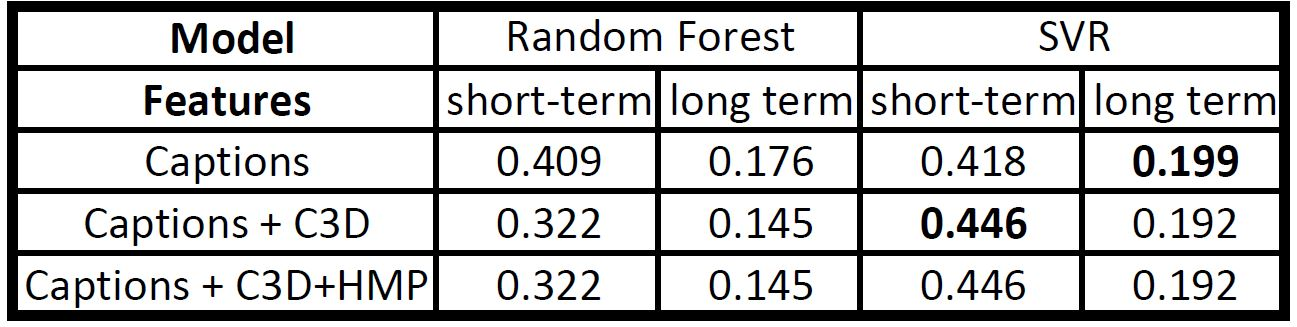

In [17]:
Image(filename="DataSheet.JPG")

## 6.  Building & Pickling Final Model

### 6.1 Training Full Dev-Set

In [18]:
final_short_term_mem_regressor,input_short_scale,pred_short_scale=svr_regression_scaled_final(captions_c3d_bag,y_short)

c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
final_long_term_mem_regressor,input_long_scale,pred_long_scale=svr_regression_scaled_final(captions_bag,y_long)

c:\users\akhil\pycharmprojects\videomemorability\venv\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 6.2 Importing test dataset for predicting memorability scores

In [21]:
#Loading Test Data
test_dataset = pd.read_csv(test_ground_truth_template_path)
test_captions = load_captions(test_captions_path)

test_c3d_features=load_c3d_features(test_captions,test_c3d_path)
test_hmp_features=load_hmp_features(test_captions,test_hmp_path)

# Cleaning and reformatting data
test_captions_bag=clean_create_caption_vector(test_captions)
test_captions_c3d_bag=combine_dataset(test_captions_bag.tolist(),test_c3d_features,len(test_captions['caption']))
test_captions_c3d_hmp_bag=combine_dataset(test_captions_c3d_bag,test_hmp_features,len(test_captions['caption']))


test_short_pred = final_short_term_mem_regressor.predict(input_short_scale.fit_transform(test_captions_c3d_bag))
test_long_pred = final_long_term_mem_regressor.predict(input_long_scale.fit_transform(test_captions_bag))

test_dataset['short-term_memorability']=pred_short_scale.inverse_transform(test_short_pred)
test_dataset['long-term_memorability']=pred_long_scale.inverse_transform(test_long_pred)

Captions Loading Progress
0% [#########                     ] 100% | ETA: 00:00:00C3D Features Loading Progress
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16
HMP Features Loading Progress
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Combining dataset
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Combining dataset
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


### 6.3 Saving memorability scores

In [22]:
test_dataset.to_csv("test_results_ground_truth.csv",index=False)
test_dataset.describe()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,8760.857500,0.866521,36.228500,0.791431,12.788000
std,730.600388,0.022438,8.407237,0.032539,3.672983
min,7494.000000,0.785250,30.000000,0.656498,9.000000
25%,8125.500000,0.852787,33.000000,0.773613,10.000000
50%,8769.000000,0.867929,33.000000,0.792900,12.000000
75%,9399.250000,0.881605,34.000000,0.809806,14.000000
max,10008.000000,0.940639,99.000000,0.911876,39.000000


## 7.  Saving final model for future

In [23]:
pickle.dump(final_short_term_mem_regressor, open(final_short_model_dump, 'wb'))
pickle.dump(final_long_term_mem_regressor, open(final_long_model_dump, 'wb'))
